In [73]:
print('What\'s up?')

What's up?


# Notebook import

In [123]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

# Constants

# Reading Files

In [75]:
#absolute path
EXAMPLE_FILE = 'D:/work/machine-learning/filter_spam_emails/SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = r'D:\work\machine-learning\filter_spam_emails\SpamData\01_Processing\spam_assassin_corpus\spam_1'
SPAM_2_PATH = r'D:\work\machine-learning\filter_spam_emails\SpamData\01_Processing\spam_assassin_corpus\spam_2'
EASY_NONSPAM_1_PATH = r'D:\work\machine-learning\filter_spam_emails\SpamData\01_Processing\spam_assassin_corpus\easy_ham_1'
EASY_NONSPAM_2_PATH = r'D:\work\machine-learning\filter_spam_emails\SpamData\01_Processing\spam_assassin_corpus\easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

In [76]:
stream = open(EXAMPLE_FILE)

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [77]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [78]:
for i in generate_squares(5):
    print(i, end = ' ->')

0 ->1 ->4 ->9 ->16 ->

# Email body extraction

In [79]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body
            

In [80]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)

    return pd.DataFrame(rows, index=row_names)

In [81]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,1))
spam_emails.head()
spam_emails.shape

(1898, 2)

In [82]:
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,1))
non_spam_emails.head()
non_spam_emails.shape

(3901, 2)

In [83]:
data = pd.concat([spam_emails, non_spam_emails])
print('Shape of the entire datafram is ', data.shape)
data.head()

Shape of the entire datafram is  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Checking for missing values

In [84]:
# check if any message bodies are null
data.MESSAGE.isnull().values.any()

False

In [85]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [86]:
(data.MESSAGE.str.len() == 0).sum()

3

In [87]:
# Challenge: how would you check the number of entries with null/None values ?
data.MESSAGE.isnull().sum()

0

## Locate empty emails

In [88]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [89]:
data[(data.MESSAGE.str.len()== 0)].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [90]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

## Remove System File Enteries from Dataframe

In [91]:
data = data.drop(['cmds'])

In [92]:
data.shape

(5796, 2)

## Add Document IDs to Track Emails in the Dataset

In [93]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [94]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [100]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace = True)
data.head()

KeyError: "None of ['DOC_ID'] are in the columns"

# Save to File using Pandas

In [101]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages visualised(Pie Charts)

In [102]:
data.CATEGORY.value_counts(1)

1    0.568668
0    0.431332
Name: CATEGORY, dtype: float64

In [98]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham  = data.CATEGORY.value_counts()[0]

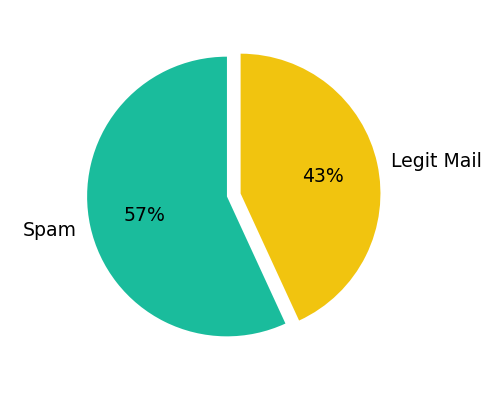

In [114]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#1abc9c', '#f1c40f']
plt.figure(figsize=(2,2), dpi=227)

#pie chart
plt.pie(sizes, labels = category_names, textprops={'fontsize': 6}, startangle=90, autopct= '%1.0f%%', colors= custom_colors, explode= [0, 0.1])

plt.show()

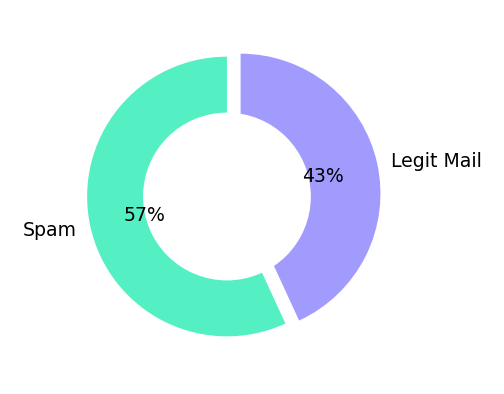

In [120]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#55efc4', '#a29bfe', '#ffeaa7', '#fd79a8']
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels = category_names, textprops={'fontsize': 6}, startangle=90, autopct= '%1.0f%%', colors= custom_colors, explode= [0, 0.1])


#Draw circles - Donut Charts
centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [121]:
# Convert to lower case
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

### Download the NLTK Resources (Tokenizer and Stopwords)